In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# Import daily bitcoin price from Jan 2nd 2009 until today


In [8]:
# Retrieved from https://data.nasdaq.com/data/BCHAIN/MKPRU-bitcoin-market-price-usd
df = pd.read_csv("data/BCHAIN-MKPRU.csv")[["Date", "Value"]]
# Convert date column to datetime type
df["Date"] = pd.to_datetime(df["Date"])
# Data is sorted from most recent to oldest, flip that
df.sort_values(by = "Date", inplace = True)
# But now indices are reversed. Reset index so that earliest date is indexed at 0.
df.reset_index(inplace = True, drop = True)
# Make this index a new column, so that we can reference it as a feature (important later).
df.reset_index(inplace = True)
df

,index,Date,Value
0,0,2009-01-02,0.00
1,1,2009-01-03,0.00
2,2,2009-01-04,0.00
3,3,2009-01-05,0.00
4,4,2009-01-06,0.00
...,...,...,...
4648,4648,2021-09-24,44888.96
4649,4649,2021-09-25,42815.56
4650,4650,2021-09-26,42742.01
4651,4651,2021-09-27,43182.63


# Bitcoin issuance

To get the actual issuance of BTC per day, we'd have to go through the block headers of the actual BTC blockchain, extract all of them, figure their exact timestamp, aggregate them by day, etc. 

For the purpose of this notebook, we'll assume there was exactly one block every 10 minutes. Since there are 1440 minutes in every day, that gives us 144 blocks/day. 

* Read more about bitcoin mining and why the average time to find a block is ~ 10 minutes [here](https://www.investopedia.com/terms/b/bitcoin-mining.asp#citation-6). 

We also know that there's a halving every 210,000 blocks. So, there's approximately 1458 days between halvings.

$$
\frac{210,000\text{ blocks}}{144\text{ }\frac{\text{blocks}}{\text{day}}} = 1458.333 \approx 1458 \text{ days}
$$

In the first era of bitcoin (Jan 3 2009 - Nov 28 2012) the reward for each block mined was 50 BTC. Since there are 144 blocks/day, the number of BTC issued per day in the first era of bitcoin was

$$
50\text{ }\frac{\text{BTC}}{\text{block}}  \times 144 \text{ }\frac{\text{blocks}}{\text{day}} = 7200\text{ }\frac{\text{BTC}}{\text{day}}
$$

After the first halving it was 25 BTC per block (or 3600 BTC issued in total per day). After the second halving, 12.5 per block (or 1800 per day) and after the third, on May 11 2020, it became 6.25 BTC per block (or 900 in total issued per day).

* Read more about bitcoin halving [here](https://www.investopedia.com/bitcoin-halving-4843769).

So the BTC issuance on any given day can be calculated as,

$$
\text{BTC issuance } = \text{ }\frac{7200 \text{ BTC}}{2^{\text{era}}}
$$

With the era for this day being calculated as,

$$
\text{era } = \text{ floor }\Bigg[\frac{\text{ days since block 0 on this day}}{\text{number of days between halvings}}\Bigg] = \text{ floor }\Bigg[\frac{\text{ days since block 0 on given day}}{\text{1458}}\Bigg]
$$

In [9]:
# Add BTC issuance as column to dataframe
df["btcIssuance"] = 7200 / 2**(np.floor(df["index"]/1458))

# Puell Multiple

* The Puell multiple explores market cycles from a mining revenue perspective.
* Bitcoin miners can be considered compulsory sellers because they need to cover fixed costs of mining hardware. Therefore, the revenue they generate influences price over time.
* The Puell Multiple is calculated by dividing the daily issuance value of BTC (in USD), by the 365-day moving average of daily issuance value.

$$
\text{Puell multiple} = \frac{\text{Daily coin issuance (USD)}}{\text{MA}_{365} \text{ (USD)}}
$$

* <span style="color:red">Red bands</span> have historically been good times to sell. 

* <span style="color:green">Green bands</span> have historically been very good times to buy.
* Read more about the Puell Multiple [here](https://medium.com/unconfiscatable/the-puell-multiple-bed755cfe358).

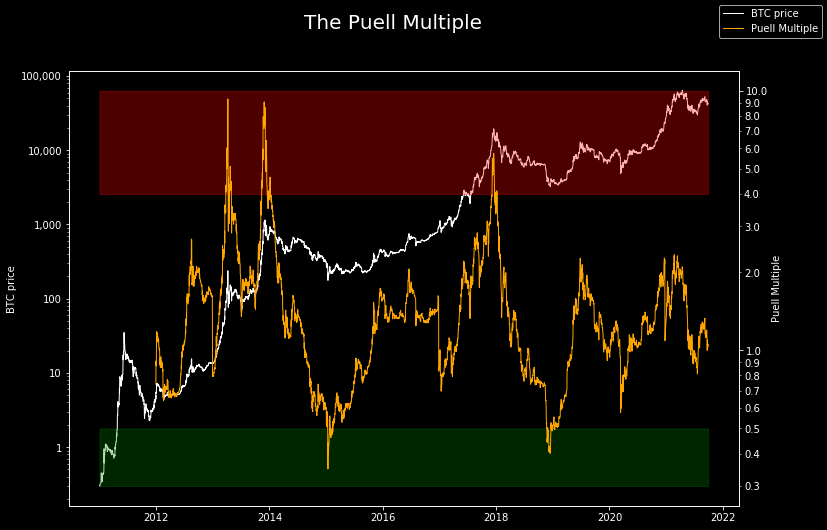

In [18]:
df["usdIssuance"] = df["btcIssuance"] * df["Value"]
df["MAusdIssuance"] = df["usdIssuance"].rolling(window=365).mean()

# Drop everything before this date
df = df[df["Date"] >= "2011-01-01"]

# Plot it
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12,8))

ax.semilogy(df["Date"], df["Value"], linewidth=1, color='white', alpha=1, label='BTC price')
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax2 = ax.twinx()

ax2.semilogy(df["Date"], df["usdIssuance"]/df["MAusdIssuance"], color='orange', linewidth=1, label='Puell Multiple')
ax2.fill_between(df["Date"], 4, 10, color="red", alpha=0.3)
ax2.fill_between(df["Date"], 0.3, 0.5, color="green", alpha=0.3)

ax2.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))
ax2.yaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))

ax2.set_ylabel("Puell Multiple")
ax.set_ylabel("BTC price")
fig.legend()
plt.suptitle('The Puell Multiple', fontsize=20)
plt.show()